<a href="https://colab.research.google.com/github/nilakshi104/Staircase-Segmentation/blob/master/Staircase_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORTING LIBRARIES

In [ ]:
from fastai.vision import open_image, open_mask, SegmentationLabelList, \
get_image_files, SegmentationItemList, get_transforms, Path, imagenet_stats, unet_learner, models, lr_find, DatasetType

from fastai.callbacks import  GeneralScheduler, TrainingPhase, EarlyStoppingCallback, SaveModelCallback
from fastai.callback import Callback, annealing_cos
from sklearn.metrics import fbeta_score   #for calculating f_score which is measure of accuracy
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import posixpath
import random


# from fastai import *
# from fastai.vision import *
# from fastai.callbacks import *
# from fastai.sgdr import *
# import glob
# import torchvision

CHECK IF NOTEBOOK IS USING CPU OR GPU

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)

cuda:0


LIST OF LABELS IS DEFINED IN TEXT FILE AND THAT FILE IS LOADED HERE


In [ ]:
colors = np.loadtxt('/content/drive/MyDrive/zero_padded_images/stair.txt',delimiter='\n',dtype=str);
colors

array(['Background', 'Stairedge'], dtype='<U10')

get_image_files RETURNS LIST OF FILES IN path_images THAT ARE IMAGES

In [ ]:
path_images='/content/drive/MyDrive/zero_padded_images/train3'
path_valid='/content/drive/MyDrive/zero_padded_images/val3'
fnames=get_image_files(path_images)

In [ ]:
fnames

In [ ]:
random.seed(4) #so evertime we run notebook we get same seq of numbers

pathlib.PosixPath

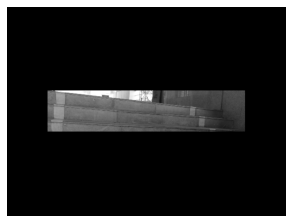

In [ ]:
img_f = fnames[0]
img = open_image(img_f) #img_f is of type Posix_path
img.show(figsize=(5,5))
type(img_f)

FUNC TO LINK IMAGES TO THEIR MASKS

In [ ]:
import posixpath
get_y_fn = lambda x: (posixpath.join('/content/drive/MyDrive/zero_padded_images/train_masks3',f'{x.stem}{x.suffix}')) if (x.parent.stem == 'train3') else (posixpath.join('/content/drive/MyDrive/zero_padded_images/val_masks3',f'{x.stem}{x.suffix}'))


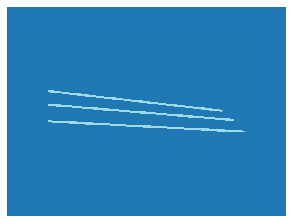

In [ ]:
mask = open_mask(get_y_fn(img_f))

mask.show(figsize=(5,5), alpha=1)

In [ ]:
mask.data #prints matrix by showing each pixel in groud_truth by its resp. class label

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [ ]:
dummy=mask.data
dummy[0,4,:]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
np.unique(mask.data) #prints class labels

array([  0, 255])

Now we have to convert class labels to [0,1] as their are 2 classes .If class number =x then class label should range from [0,x-1]

For that will pass div argument as True in open function of SegLabelListCustom class which is child class of SegmentationLabelList

 by using div=True 0/255=0,255/255=1

In [ ]:
class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [ ]:
src_size = np.array(mask.shape[1:])
src_size

array([480, 640])

In [ ]:
"""Run this for training as during training size is 1/2 nd testing size is same as original (480,640)"""
src = (SegItemListCustom.from_folder(Path('/content/drive/MyDrive/zero_padded_images/'))
   .split_by_folder(train='train3',valid='val3')
   .label_from_func(get_y_fn, classes=colors)
   .transform(get_transforms(),tfm_y=True, size=(240,320))#tfms_y=True because transforms we r applying on trainset,will be also applied on train_masks
  #  .add_test_folder(test_folder='test',tfms=None,tfm_y=False) #since test_masks are empty we dont need tfms on ground truth here so tfm_y=False
   )

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [ ]:
# cl = CategoryList(src.train.y.items, src.train.y.classes); cl
src.train.y.classes

array(['Background', 'Stairedge'], dtype='<U10')

In [ ]:
src.test

In [ ]:
# tfms = get_transforms(do_flip=True,size=src_size//2)
data = (src
        .databunch(bs=8)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (771 items)
x: SegItemListCustom
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: SegLabelListCustom
ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320)
Path: /content/drive/MyDrive/zero_padded_images;

Valid: LabelList (97 items)
x: SegItemListCustom
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: SegLabelListCustom
ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320)
Path: /content/drive/MyDrive/zero_padded_images;

Test: None

In [ ]:
# data.train_ds[0][1].data
np.unique(data.train_ds[0][1].data)
# data.valid_ds[0][1]
# data.valid_ds[0][0]

array([0, 1])

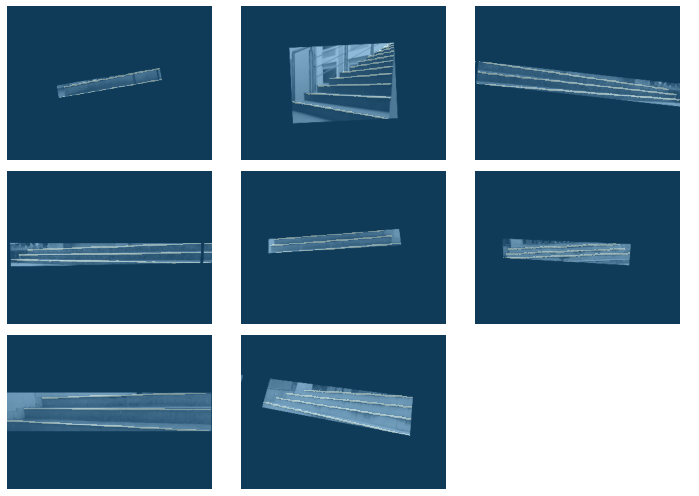

In [ ]:
data.show_batch(figsize=(10,7)) #in case of sementic segmentation masks are overlapped on images so stair_edges are yellow and background is blue

[link text](https://www.google.com/url?sa=i&url=https%3A%2F%2Fbecominghuman.ai%2Finvestigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c&psig=AOvVaw3pwRINI02Q3a57KqHGCigW&ust=1588867703677000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCOjD28vPn-kCFQAAAAAdAAAAABAD)


In [ ]:
#method1:
# class FocalLoss(nn.Module):
#     def __init__(self, ):
#         super(FocalLoss,self).__init__()
#     def forward(self,inputs,targets):
#         #IN CE REDUCTION IS BYDEFAULT SET TO MEAN
#         CE_loss=torch.nn.CrossEntropyLoss(weight=(torch.tensor([1.,50.])).to(device))(inputs,targets.squeeze(1))
#         return CE_loss

In [ ]:
# method2
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.,gamma=2.,reduction='mean'):
        super(FocalLoss,self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction=reduction

    def forward(self, inputs, targets):
        CE_loss = torch.nn.CrossEntropyLoss(reduction=self.reduction)(inputs, targets.squeeze(1))
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
#         if self.reduction is None:
#             return F_loss
#         else:
#             return torch.mean(F_loss)
        return F_loss

[link text](https://www.google.com/url?sa=i&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FF1_score&psig=AOvVaw2xNbYjeRcG_MjA_nq14IuR&ust=1588868231066000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCKCslafSn-kCFQAAAAAdAAAAABAD)

F0.5_score=when beta=0.5,more attention is given on precision(false_positives are more imp  to minimize but fasle_negatives are still imp)

F1_score=when beta=1,recall and precision have balanced weight

F2_score=when beta=2,more attention is given on recall(false_negatives are more imp  to minimize but fasle_positives are still imp)

[link text](https://www.google.com/url?sa=i&url=https%3A%2F%2Fmikulskibartosz.name%2Ff1-score-explained%2F&psig=AOvVaw3QBsmhfrmqM7Fthow-8n9Q&ust=1588868556033000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNiolv3Sn-kCFQAAAAAdAAAAABAD)

minor elements are considered as positive elements so we need to minimize false_negatives (i.e. cases where stair_edges are detected as background)
so here will use beta=2

In [ ]:
#FOR SINGLE IMG

def f2_score(input,target):
  f=0
  input=input.to("cpu")
  target=target.to("cpu")
  input=input.argmax(dim=1)
  for i in range(input.shape[0]):
    input1=input[i,:,:]
    input1=input1.reshape(-1,1)
    input1=input1.squeeze(1)
    target1=target[i,:,:]
    target1=target1.reshape(-1,1)
    target1=target1.squeeze(1)
    # precision_score(targets, inputs, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    # recall_score(targets,inputs, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    k=fbeta_score(target1, input1, beta=2)
    f+=k

  return torch.tensor(f/input.shape[0])

In [ ]:
# def accu(input, target):
#     target = target.squeeze(1)
#     return (input.argmax(dim=1)==target).float().mean()

# accuracy=accu
f2_score=f2_score
loss_func1 = FocalLoss()
wd=1e-6

In [ ]:
def fit_sgd_warm(learn,n_cycles,lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n * (cycle_len * cycle_mult**i))
                 .schedule_hp('lr', lr, anneal=annealing_cos)
                 .schedule_hp('mom', mom)) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
    learn.fit(total_epochs)

LOAD unet_learner

For the first half of training, the ResNet-34 encoder is initialized with pretrained weights on the ImageNet dataset.

By freezing encoder weights, decoder weights are updated.

Here we need not to call learn.freeze() explicitly as intially encoder and decoder weights are in freezed and unfreezed state respectively. 

learn.freeze() -> freeze enocder weights

learn.unfreeze() -> unfreeze enocder weights

In [ ]:
learn = unet_learner(data,models.resnet34, metrics=f2_score, loss_func=loss_func1,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

FOR GPU USAGE WARNING, TRY EMPTYING CACHE

In [ ]:
torch.cuda.empty_cache()

In [ ]:
fit_sgd_warm(learn,n_cycles=2,lr=1e-6,mom=0.9,cycle_len=1,cycle_mult=2)   # ******************THESE PARA NEEDS TO BE TUNED***************

epoch,train_loss,valid_loss,f2_score,time
0,0.000015,0.000241,0.708691,01:59


FOR CREATING .pt FILE --> bydefault, here freezed model is stored i.e. encoder weights are freezed (same as resnet pretrained model), only decoder weights are updated during training.


In [ ]:
learn.save('w1')  #save freezed model w1

FOR CREATING .pkl FILE

In [ ]:
learn.export()

LOADING MODEL

In [ ]:
learn.load('w1') #LOADING LATEST SAVED MODEL

learn.unfreeze() updates weights of encoder and decoder when trained using fit_sgd_warm

In [ ]:
learn.unfreeze() #unfreeze model (encoder weights are updatable! train model further to update both encoder and decoder weights)
lr_find(learn)
learn.recorder.plot() #use output of learn.recorder.plot() to decide lr

In [ ]:
fit_sgd_warm(learn,n_cycles=2,lr=1e-6,mom=0.9,cycle_len=1,cycle_mult=2)

In [ ]:
learn.save('w1')  #save unfreezed model w1 ..this overwrites earlier saved freezed model w1

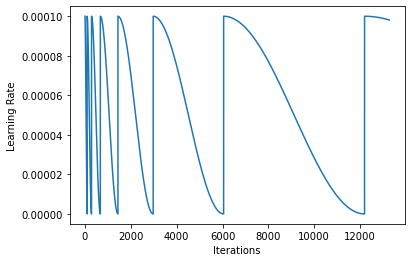

In [ ]:
learn.recorder.plot_lr()   #Cossine Anneling

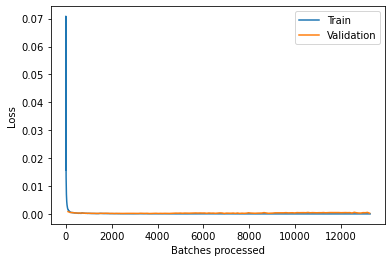

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(learn.loss)
learn.recorder.plot_losses()

TO INCREASE F SCORE BY 1-2 percent Further, MAKE IMAGE SIZE AS ORIGINAL (IN TRAINING THOUGH WE USED HALF OF SIZE) and train again.

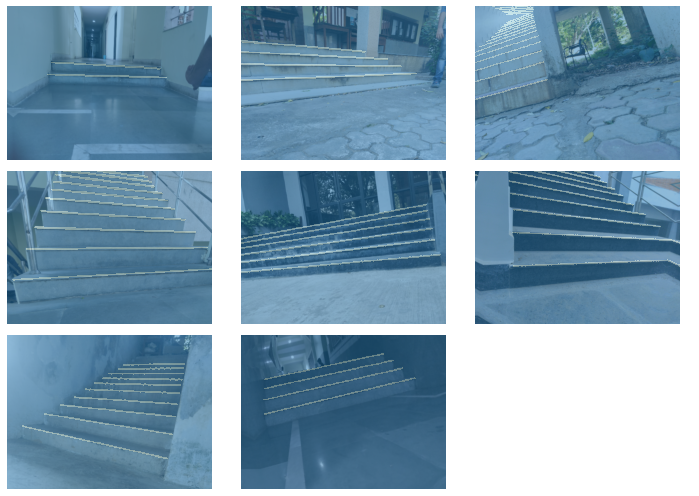

In [ ]:
src = (SegItemListCustom.from_folder(Path('/content/drive/MyDrive/Stair dataset1'))
   .split_by_folder(train='train',valid='val')
   .label_from_func(get_y_fn, classes=colors)
   .transform(get_transforms(),tfm_y=True, size=src_size)#tfms_y=True because transforms we r applying on trainset,will be also applied on train_masks
   .add_test_folder(test_folder='test',tfms=None,tfm_y=False)#since test_masks are empty we dont need tfms on ground truth here so tfm_y=False
   )

data = (src
        .databunch(bs=8)
        .normalize(imagenet_stats))

data.show_batch(figsize=(10,7)) 

In [ ]:
learn.data=data
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
torch.cuda.empty_cache()
fit_sgd_warm(learn,n_cycles=3,lr=1e-4,mom=0.9,cycle_len=1,cycle_mult=2)

In [ ]:
learn.unfreeze()
fit_sgd_warm(learn,n_cycles=3,lr=1e-4,mom=0.9,cycle_len=1,cycle_mult=2)

epoch,train_loss,valid_loss,f2_score,time
0,0.000096,0.000115,0.624656,02:26


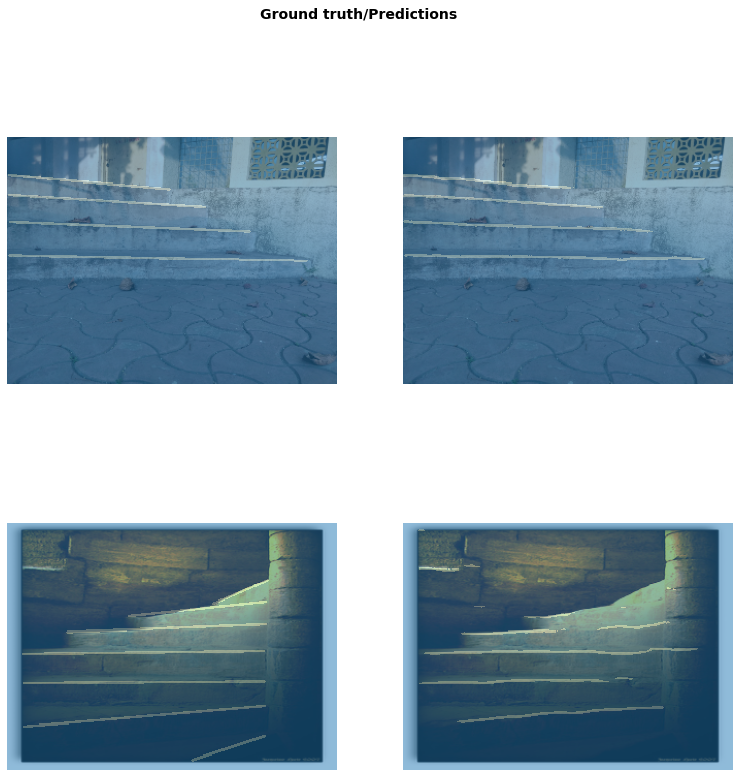

In [ ]:
k=learn.show_results(rows=2, figsize=(13,13))

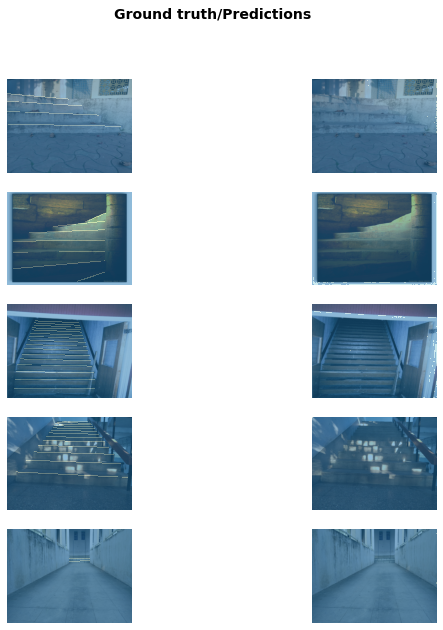

In [ ]:
k=learn.show_results(figsize=(10,10))

THIS MARKS END OF TRAINING CODE!!!

In [ ]:
# learn.fit_one_cycle??      #to check documentation

# lr=1e-4
# #1
# lr_set=[1e-4 , 1e-5 , (1e-5)/2]
# learn.fit_one_cycle(3,lr_set,cycle_len=1)

#2:Cosine Anneling
# learn.fit(epochs=1,lr=lr)    #where 0.1 is max lr then lr decreases in cosine graph fashion till end

#3:Stochastic Gradient Descent with restart
#method1:
# learn.fit(epochs,learning_rate)    #lr is reset at the start of each epoch to 'learning_rate' value v specified the decrease again over epoch in cosine annealing fashion

#method2:
# cycle_len=1 #decide how many epochs it takes for lr to fall to its min point.Here as specified 1 epoch
# cycle_mult=2 #at the end of each_cycle,multiply cycle_len by 2
# learn.fit(epochs,learning_rate,cycle_len=1,cycle_mult=2)
#in this case there will be three restarts.THe first time with cycle_len of 1,so it will take 1 epoch to complete cycle.cycle_mult=2 so next cycle will have 2 epochs then next 4 epochs and so on

# learn.validate()
# learn.show_results(ds_type=DatasetType.Valid)

# interp=ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()
# # learn = cnn_learner(data, models.resnet18)
# # learn.fit(1)
# preds,y,losses = learn.get_preds(with_loss=True)
# interp = ClassificationInterpretation(learn, preds, y, losses)
# interp

# 'print(img_f)' #prints /content/gdrive/My Drive/Untitled folder/stair_dataset/train/989.png
# 'print(img_f.parent.parent)' #prints /content/gdrive/My Drive/Untitled folder/stair_dataset
# 'print(img_f.parent)' #prints /content/gdrive/My Drive/Untitled folder/stair_dataset/train
# 'print(img_f.stem)' #prints 989
# 'print(img_f.name)' #prints 989.png
# 'posixpath.join(img_f.parent,'_labels')' #prints '/content/gdrive/My Drive/Untitled folder/stair_dataset/train/_labels'

#for unzippping

# import zipfile

# with zipfile.ZipFile('train_masks.zip','r') as zip_ref:
#     zip_ref.extractall('train_masks')

# with zipfile.ZipFile('train.zip','r') as zip_ref:
#     zip_ref.extractall('train')
    
# with zipfile.ZipFile('val_masks.zip','r') as zip_ref:
#     zip_ref.extractall('val_masks')

# with zipfile.ZipFile('val.zip','r') as zip_ref:
#     zip_ref.extractall('val')

# with zipfile.ZipFile('test_masks.zip','r') as zip_ref:
#     zip_ref.extractall('test_masks')

# with zipfile.ZipFile('test.zip','r') as zip_ref:
#     zip_ref.extractall('test')